# Class Inbalance in Binary Classification  
### Aprendizagem Computacional 1

**João Pedro Nunes Rocha** — up202306599  
**Paulo Diogo Lopes Pinto** — up202306412  
**Rui Filipe Rocha Alvarilhão** — up202209089  

Implementação baseada no algoritmo **XGBoost**, com modificações para lidar com o desbalanceamento de classes.


# Bibliotecas necessárias

Para executar este código, é necessário instalar as seguintes bibliotecas:

- numpy -> 2.2.3
- pandas -> 2.2.3
- scikit-learn -> 1.6.1
- imbalanced-learn -> 0.13.0
- matplotlib -> 3.10.0
- seaborn -> 0.13.2
- scipy -> 1.15.2

In [1]:
import numpy as np
import os
from scipy.special import expit
from scipy.stats import norm
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.metrics import roc_auc_score,recall_score, f1_score,confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import  mutual_info_classif
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import math
import seaborn as sns
from imblearn.metrics import geometric_mean_score

# Modificações ao Algoritmo XGBoost

Para melhorar o desempenho do modelo em cenários com desbalanceamento de classes, foram introduzidas as seguintes modificações ao algoritmo XGBoost:

- **Seleção de Features por Mutual Information**  
  Foi utilizada a métrica de *Mutual Information* para selecionar as variáveis mais relevantes, com o objetivo usar features com maior poder preditivo.

- **Log-Loss Ponderado**  
  A função de perda foi ajustada para penalizar mais os erros na classe minoritária, aumentando a sensibilidade do modelo para essa classe.

- **Calibração do Threshold com G-Mean**  
  O limiar de decisão padrão (0.5) foi calibrado utilizando a métrica *G-Mean*, a fim de equilibrar a taxa de verdadeiros positivos e verdadeiros negativos, maximizando a performance em datasets desbalanceados.


# Algoritmo Modificado

In [80]:
class BaseEstimator:
    y_required = True
    fit_required = True

    def _setup_input(self, X, y=None):
        """Ensure inputs to an estimator are in the expected format.

        Ensures X and y are stored as numpy ndarrays by converting from an
        array-like object if necessary. Enables estimators to define whether
        they require a set of y target values or not with y_required, e.g.
        kmeans clustering requires no target labels and is fit against only X.

        Parameters
        ----------
        X : array-like
            Feature dataset.
        y : array-like
            Target values. By default is required, but if y_required = false
            then may be omitted.
        """
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if X.size == 0:
            raise ValueError("Got an empty matrix.")

        if X.ndim == 1:
            self.n_samples, self.n_features = 1, X.shape
        else:
            self.n_samples, self.n_features = X.shape[0], np.prod(X.shape[1:])

        self.X = X

        if self.y_required:
            if y is None:
                raise ValueError("Missed required argument y")

            if not isinstance(y, np.ndarray):
                y = np.array(y)

            if y.size == 0:
                raise ValueError("The targets array must be no-empty.")

        self.y = y

    def fit(self, X, y=None):
        self._setup_input(X, y)

    def predict(self, X=None):
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if self.X is not None or not self.fit_required:
            return self._predict(X)
        else:
            raise ValueError("You must call `fit` before `predict`")

    def _predict(self, X=None):
        raise NotImplementedError()

## Tree

In [81]:
def xgb_criterion(y, left, right, loss):
    left = loss.gain(left["actual"], left["y_pred"])
    right = loss.gain(right["actual"], right["y_pred"])
    initial = loss.gain(y["actual"], y["y_pred"])
    gain = left + right - initial
    return gain

In [82]:
def split(X, y, value):
    left_mask = X < value
    right_mask = X >= value
    return y[left_mask], y[right_mask]

In [83]:
def get_split_mask(X, column, value):
    left_mask = X[:, column] < value
    right_mask = X[:, column] >= value
    return left_mask, right_mask

In [84]:
def split_dataset(X, target, column, value, return_X=True):
    left_mask, right_mask = get_split_mask(X, column, value)

    left, right = {}, {}
    for key in target.keys():
        left[key] = target[key][left_mask]
        right[key] = target[key][right_mask]

    if return_X:
        left_X, right_X = X[left_mask], X[right_mask]
        return left_X, right_X, left, right
    else:
        return left, right

In [ ]:
class Tree(object):
    """Recursive implementation of decision tree."""

    def __init__(self, regression=False, criterion=None, n_classes=None):
        self.regression = regression
        self.impurity = None
        self.threshold = None
        self.column_index = None
        self.outcome = None
        self.criterion = criterion
        self.loss = None
        self.n_classes = n_classes 

        self.left_child = None
        self.right_child = None

    @property
    def is_terminal(self):
        return not bool(self.left_child and self.right_child)

    def _find_splits(self, X):
        """Find all possible split values."""
        split_values = set()

        # Get unique values in a sorted order
        x_unique = list(np.unique(X))
        for i in range(1, len(x_unique)):
            # Find a point between two values
            average = (x_unique[i - 1] + x_unique[i]) / 2.0
            split_values.add(average)

        return list(split_values)

    def _find_best_split(self, X, target, features):
        """Find best feature and value for a split. Greedy algorithm."""

        max_gain, max_col, max_val = None, None, None

        for column in features:
            split_values = self._find_splits(X[:, column])
            for value in split_values:
                # Gradient boosting
                left, right = split_dataset(X, target, column, value, return_X=False)
                gain = xgb_criterion(target, left, right, self.loss)

                if (max_gain is None) or (gain > max_gain):
                    max_col, max_val, max_gain = column, value, gain
        return max_col, max_val, max_gain

    def _train(self, X, target, features=None, min_samples_split=10, max_depth=None, minimum_gain=0.01):
        try:
            # Exit from recursion using assert syntax
            assert X.shape[0] > min_samples_split
            assert max_depth > 0


            column, value, gain = self._find_best_split(X, target, features)
            assert gain is not None
            if self.regression:
                assert gain != 0
            else:
                assert gain > minimum_gain

            self.column_index = column
            self.threshold = value
            self.impurity = gain

            # Split dataset
            left_X, right_X, left_target, right_target = split_dataset(X, target, column, value)

            # Grow left and right child
            self.left_child = Tree(self.regression, self.criterion, self.n_classes)
            self.left_child.loss = self.loss
            self.left_child._train(
                left_X, left_target, features, min_samples_split, max_depth - 1, minimum_gain
            )

            self.right_child = Tree(self.regression, self.criterion, self.n_classes)
            self.right_child.loss = self.loss
            self.right_child._train(
                right_X, right_target, features, min_samples_split, max_depth - 1, minimum_gain
            )
            
        except AssertionError:
            self._calculate_leaf_value(target)

    def train(self, X, target, features=None, min_samples_split=10, max_depth=None, minimum_gain=0.01, loss=None):
        """Build a decision tree from training set.

        Parameters
        ----------

        X : array-like
            Feature dataset.
        target : dictionary or array-like
            Target values.
        features : array
            Lista de colunas que apresentam maior mutual information em relação à variável alvo.
            Essas features são consideradas mais relevantes para prever o target.
        min_samples_split : int
            The minimum number of samples required to split an internal node.
        max_depth : int
            Maximum depth of the tree.
        minimum_gain : float, default 0.01
            Minimum gain required for splitting.
        loss : function, default None
            Loss function for gradient boosting.
        """

        if not isinstance(target, dict):
            target = {"y": target}

        # Loss for gradient boosting
        if loss is not None:
            self.loss = loss

        if not self.regression:
            self.n_classes = len(np.unique(target['y']))

        self._train(X, target, features=features, min_samples_split=min_samples_split,
                    max_depth=max_depth, minimum_gain=minimum_gain)


    def _calculate_leaf_value(self, targets):
        """Find optimal value for leaf."""
        # Gradient boosting
        self.outcome = self.loss.approximate(targets["actual"], targets["y_pred"])

    def predict_row(self, row):
        """Predict single row."""
        if not self.is_terminal:
            if row[self.column_index] < self.threshold:
                return self.left_child.predict_row(row)
            else:
                return self.right_child.predict_row(row)
        return self.outcome

    def predict(self, X):
        result = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            result[i] = self.predict_row(X[i, :])
        return result

## Gradient Boosting

In [86]:
def mse_criterion(y, splits):
    y_mean = np.mean(y)
    return -sum([np.sum((split - y_mean) ** 2) * (float(split.shape[0]) / y.shape[0]) for split in splits])

In [87]:
class Loss:
    """Base class for loss functions."""
    def __init__(self, regularization=1.0):
        self.regularization = regularization

    def transform(self, pred):
        """Transform prediction values."""
        return pred

    def approximate(self, actual, predicted):
        """Approximate leaf value."""
        return self.grad(actual, predicted).sum() / (
            self.hess(actual, predicted).sum() + self.regularization
        )

    def gain(self, actual, predicted):
        """Calculate gain for split search."""
        g = self.grad(actual, predicted).sum()
        h = self.hess(actual, predicted).sum() + self.regularization
        return 0.5 * (g * g) / h

In [ ]:
class LogisticLoss(Loss):
    """Logistic loss com ponderação por classe."""
    def __init__(self, class_weights, regularization=1.0):
        super().__init__(regularization)
        # class_weights é um dicionário que associa cada classe a um peso
        self.class_weights = class_weights

    def grad(self, actual, predicted):
        """
        Calcula o gradiente da perda logística ponderada.
        
        Parâmetros:
        - actual: array com os rótulos verdadeiros (-1 ou 1)
        - predicted: array com os valores previstos (output bruto do modelo)

        Retorna:
        - gradiente da função de perda, ponderado por classe
        """

        if len(actual) == 0: return np.array([])

        # Obtém os pesos correspondentes a cada classe nos rótulos reais
        w = np.vectorize(self.class_weights.get)(actual)

        # Calcula o gradiente: derivada da logistic loss em relação às predições
        # Fórmula: (2y - 1) * sigmoid(-(2y - 1) * f(x))
        g = (2 * actual - 1) * expit(-(2 * actual - 1) * predicted)

        # Aplica a ponderação por classe
        return w * g

    def hess(self, actual, predicted):
        """
        Calcula a hessiana (segunda derivada) da perda logística ponderada.
        
        Parâmetros:
        - actual: array com os rótulos verdadeiros (-1 ou 1)
        - predicted: array com os valores previstos (output bruto do modelo)

        Retorna:
        - segunda derivada da função de perda, ponderada por classe
        """
        if len(actual) == 0: return np.array([])

        # Obtém os pesos para cada instância com base na classe
        w = np.vectorize(self.class_weights.get)(actual)

        # Aplica a função sigmoide nas predições
        p = expit(predicted)

        # Hessiana da perda logística: p * (1 - p)
        h = p * (1 - p)

        # Aplica a ponderação por classe
        return w * h

    def transform(self, output):
        """
        Transforma a predição bruta do modelo em probabilidade via função sigmoide.

        Parâmetros:
        - output: valores brutos de predição

        Retorna:
        - probabilidades no intervalo [0, 1]
        """
        
        return expit(output)

In [ ]:
class GradientBoosting(BaseEstimator):
    """Gradient boosting trees with Taylor's expansion approximation (as in xgboost)."""

    def __init__(self, n_estimators, learning_rate=0.1, features= None, max_depth=2, min_samples_split=10):
        self.min_samples_split = min_samples_split
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.features = features
        self.n_estimators = n_estimators
        self.trees = []
        self.loss = None

    def fit(self, X, y=None):
        self._setup_input(X, y)
        self.y_mean = np.mean(y)
        self._train()

    def _train(self):
        # Initialize model: mean
        y_pred = np.full(self.n_samples, self.y_mean)

        for n in range(self.n_estimators):
            residuals = self.loss.grad(self.y, y_pred)
            tree = Tree(regression=False, criterion=mse_criterion)
            
            # Pass multiple target values to the tree learner
            targets = {
                # Residual values
                "y": residuals,
                # Actual target values
                "actual": self.y,
                # Predictions from previous step
                "y_pred": y_pred,
            }

            tree.train(
                self.X,
                targets,
                features=self.features,
                min_samples_split=self.min_samples_split,
                max_depth=self.max_depth,
                loss=self.loss,
            )

            predictions = tree.predict(self.X)
            y_pred += self.learning_rate * predictions
            self.trees.append(tree)

    def _predict(self, X=None):
        y_pred = np.zeros(X.shape[0], np.float32)

        for i, tree in enumerate(self.trees):
            y_pred += self.learning_rate * tree.predict(X)
        return y_pred

    def predict(self, X=None):
        return self.loss.transform(self._predict(X))

In [90]:
class GradientBoostingClassifier(GradientBoosting):
    def fit(self,class_weights, X, y=None):
        # Convert labels from {0, 1} to {-1, 1}
        y = (y * 2) - 1
        self.loss = LogisticLoss(class_weights)
        super(GradientBoostingClassifier, self).fit(X, y)

# Executar Algoritmo e Obter Dados

Para garantir que o cálculo da *Mutual Information* (MI) refletisse corretamente a relação entre cada feature e as classes, foi realizada imputação condicionada à classe:

- **Features numéricas**: preenchimento pela **mediana** dentro de cada classe.  
- **Features categóricas**: preenchimento pela **moda** dentro de cada classe.

Essa abordagem preserva as distribuições originais de cada classe, evitando enviesamentos causados pela classe maioritária.


In [ ]:
def fillNan(df):
    """
    Preenche valores NaN no DataFrame:
    - colunas numéricas: preenche com a mediana do grupo definido pela última coluna
    - colunas categóricas: preenche com o modo do grupo definido pela última coluna

    Parâmetros:
    -----------
    df : pandas.DataFrame

    Retorna:
    --------
    pandas.DataFrame com valroes NaN preenchidos.
    """
    df_target = df.columns[-1]
    num_cols = df.select_dtypes(include=[np.number]).columns.drop(df_target, errors='ignore')
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.drop(df_target, errors='ignore')

    for col in num_cols:
        medians = df.groupby(df_target)[col].transform('median')
        df[col] = df[col].fillna(medians)
    
    for col in cat_cols:
        modes = (df.groupby(df_target)[col].agg(lambda x: x.mode().iat[0] if not x.mode().empty else np.nan))
        df[col] = df[col].fillna(df[df_target].map(modes))
    
    return df

In [ ]:
def get_weights(y_train):
    """
    As targets são convertidas de {0,1} para {-1,1}, uma vez que algoritmo trabalha com os valores desta forma
    Calcula pesos para cada classe {-1,1}

    Parâmetros:
    -----------
    y_train : array 
        Valores binários -> 0 ou 1.

    Retorna:
    --------
    dict
        Dicionário com pesos das classes para as classes {-1, 1}, onde cada peso
        é o inverso da frequência da classe no conjunto de treino, usado para balancear as classes.
    """
    y_train_mapped = (y_train * 2) - 1
    classes = np.array([-1,1])
    ws = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_mapped)
    class_weights = { -1: ws[0], 1: ws[1] }  
    return class_weights

In [ ]:
def findThresholdGmean(probs, y):
    """
    Encontra o Threshold que maximiza a métrica geometric mean (G-mean) 
    para probabilidades previstas pelo modelo

    Parâmetros:
    -----------
    probs : array
        Probabilidades previstas pelo modelo (valores entre 0 e 1).
    y : array
        Classes reais binários (0 ou 1).

    Retorna:
    --------
    float
        Threshold que maximiza o G-mean.
    """

    thresholds = np.unique(probs)

    best_t, best_g = None, -1
    for t in thresholds:
        preds = (probs >= t).astype(int)
        g = geometric_mean_score(y, preds)
        if g > best_g:
            best_t, best_g = t, g

    if best_t is None:
        thresholds = np.linspace(0, 1, 101)
        for t in thresholds:
            preds = (probs >= t).astype(int)
            g = geometric_mean_score(y, preds)
            if g > best_g:
                best_t, best_g = t, g

    print(f"Threshold ótimo (G-mean): {best_t:.2f} → G-mean: {best_g:.3f}")
    return best_t

In [ ]:
def bestCorrelation(X, y, n):
    """
    Seleciona os índices das n melhores variáveis preditoras do conjunto de treino
    com base no MI em relação à variável alvo.

    Parâmetros:
    -----------
    X : array
        Conjunto de treino com as variáveis preditoras.
    y : array
        Classes reais do conjunto de treino.
    n : int
        Quantidade de variáveis a selecionar.

    Retorna:
    --------
    numpy.ndarray
        Índices das n variáveis com maior informação mútua.
    """
    
    # Calcula MI
    mi_scores = mutual_info_classif(X, y, n_neighbors=20, random_state=42)

    # argsort retorna índices que ordenariam o array; usamos [::-1] para decrescente
    sorted_idx = np.argsort(mi_scores)[::-1]
    top_n_idx = sorted_idx[:n]
    
    return top_n_idx

In [ ]:
"""

Objetivos:
----------
- Avaliar modelos em datasets variados com classes desbalanceadas.
- Preservar proporção das classes em cada fold usando StratifiedKFold.
- Coletar métricas importantes: ROC AUC, Recall, Specificity e F1-score.
- Salvar métricas agregadas para análise posterior.

    
Pipeline de treino e avaliação com Stratified K-Fold Cross-Validation.
    
Processo:
---------
- Para cada ficheiro CSV numa pasta:
    - Carrega e pré-processa os dados, remove colunas que têm apenas valores Nans e preenche os restantes NaNs.
    - Converte as variáveis categóricas para valores numéricos usando LabelEncoder.
    - Extrai as features e as classes alvo.
    - Realiza Stratified K-Fold, com k = 5, para validação cruzada estratificada.
    - Em cada fold:
        - Separa treino e teste.
        - Divide treino em treino e validação interna para calibração do threshold.
        - Seleciona as melhores features usando MI no treino.
        - Treina um modelo GradientBoostingClassifier com pesos balanceados.
        - Ajusta o threshold para maximizar geometric mean na validação.
        - Avalia no teste e calcula métricas -> ROC AUC, Recall, Especificidade, F1.
    - Agrega métricas médias por dataset.
- Salva as métricas finais num CSV.

Variáveis principais:
---------------------
- folder_path : caminho da pasta com OS datasets.
- output_csv : caminho para salvar o CSV final com as métricas.
- K : número de folds na cross-validation.
- all_metrics : lista onde são guardadas métricas médias por dataset.

Parâmetros e configurações:
---------------------------
- n_splits=5 para StratifiedKFold.
- GradientBoostingClassifier com n_estimators=50, max_depth=4, max_features=√(n_features), learning_rate=0.1.
- Random state fixo para reprodutibilidade.

Resultado:
----------
Um CSV contendo métricas médias (ROC_AUC, Recall, Specificity, F1) para cada dataset processado,
facilitando comparação de desempenho entre datasets com diferentes níveis de balanceamento.

"""

folder_path = "class_imbalance/"
output_csv = "relatorio_com_mod.csv"
K = 5  
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=1111)

all_metrics = []

for filename in os.listdir(folder_path):

    # Carregar e pré-processar dataset
    df = pd.read_csv(os.path.join(folder_path, filename))
    df = df.dropna(axis=1, how='all')
    df = fillNan(df)

    le = LabelEncoder()
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = le.fit_transform(df[col])
            
    feature_names = df.columns[:-1].tolist()
    X = df.iloc[:, :-1].to_numpy()
    y = df.iloc[:,-1].to_numpy()
    y = np.where(y == -1, 0, y)
    
    fold_metrics = []

    # Loop de cross-validation estratificada
    for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):
        X_trainval, y_trainval = X[train_idx], y[train_idx]
        X_test,  y_test  = X[test_idx],  y[test_idx]

        # Split interno para calibração de threshold (80% treino / 20% validação)
        X_train, X_val, y_train, y_val = train_test_split(
            X_trainval, y_trainval, test_size=0.2, stratify=y_trainval, random_state=fold_idx
        )

        seletected_features = bestCorrelation(X_train,y_train,n = math.ceil(math.sqrt(X.shape[1])),)
        print(seletected_features)

        # Distribuição de classes
        unique_train, counts_train = np.unique(y_train, return_counts=True)
        print(f"\n[{filename}] Fold {fold_idx} – train dist: {dict(zip(unique_train, counts_train))}")
        unique_test, counts_test = np.unique(y_test, return_counts=True)
        print(f"[{filename}] Fold {fold_idx} – test  dist: {dict(zip(unique_test, counts_test))}\n")

        # Treino do modelo
        model = GradientBoostingClassifier(
            n_estimators=50,
            max_depth=4,
            features= seletected_features,
            learning_rate=0.1
        )
        
        class_weights = get_weights(y_train)
        print(f"Fold {fold_idx} - pesos: {class_weights}")
        model.fit(class_weights,X_train, y_train)

        # Calibração do threshold com validação interna
        probs = model.predict(X_val)
        best_threshold = findThresholdGmean(probs,y_val)

        # Teste com threshold calibrado
        probs_test = model.predict(X_test)
        final_preds = (probs_test >= best_threshold).astype(int)

        # Métricas por fold
        roc_auc = roc_auc_score(y_test, final_preds)
        recall = recall_score(y_test, final_preds)
        tn, fp, fn, tp = confusion_matrix(y_test, final_preds).ravel()
        specificity = tn / (tn + fp)
        f1 = f1_score(y_test, final_preds)

        fold_metrics.append({
            'fold': fold_idx,
            'ROC_AUC': roc_auc,
            'Recall': recall,
            'Specificity': specificity,
            'F1': f1
        })

    # Agrega métricas dos folds
    df_fold = pd.DataFrame(fold_metrics)
    mean_metrics = df_fold.mean(numeric_only=True).to_dict()
    mean_metrics['DataSet'] = filename
    all_metrics.append(mean_metrics)

# Salvar métricas agregadas
metrics_df = pd.DataFrame(all_metrics)
columns = ['DataSet', 'ROC_AUC', 'Recall', 'Specificity', 'F1']
metrics_df = metrics_df[columns]
metrics_df.to_csv(output_csv, index=False)
print(f"All metrics (mean over {K} folds) saved to {output_csv}")

[16 14 15 50 93  4 80 39 49 78]

[dataset_1045_kc1-top5.csv] Fold 1 – train dist: {np.int64(0): np.int64(5), np.int64(1): np.int64(87)}
[dataset_1045_kc1-top5.csv] Fold 1 – test  dist: {np.int64(0): np.int64(2), np.int64(1): np.int64(27)}

Fold 1 - pesos: {-1: np.float64(9.2), 1: np.float64(0.5287356321839081)}
Threshold ótimo (G-mean): 0.91 → G-mean: 0.000
[15 14 16  0 79 77 40 78 92 37]

[dataset_1045_kc1-top5.csv] Fold 2 – train dist: {np.int64(0): np.int64(5), np.int64(1): np.int64(87)}
[dataset_1045_kc1-top5.csv] Fold 2 – test  dist: {np.int64(0): np.int64(2), np.int64(1): np.int64(27)}

Fold 2 - pesos: {-1: np.float64(9.2), 1: np.float64(0.5287356321839081)}
Threshold ótimo (G-mean): 0.88 → G-mean: 0.933
[14 93 80 81 85 84 88 90 82 91]

[dataset_1045_kc1-top5.csv] Fold 3 – train dist: {np.int64(0): np.int64(5), np.int64(1): np.int64(87)}
[dataset_1045_kc1-top5.csv] Fold 3 – test  dist: {np.int64(0): np.int64(2), np.int64(1): np.int64(27)}

Fold 3 - pesos: {-1: np.float64(9.2), 1:

# Analise de Dados

In [2]:
df_nao_mod = pd.read_csv("relatorio_sem_mod_Gmean.csv") 
# Carrega o dataset original (sem modificações) para comparações futuras na análise dos dados

**Métrica G-mean (Geometric Mean)**

A métrica **G-mean** (média geométrica) é utilizada para avaliar o desempenho de classificadores, especialmente em problemas de classificação binária **com dados desbalanceados**.

**Fórmula**:
$$\text{G-mean} = \sqrt{\text{Recall} \times \text{Specificity}}$$

- **Recall** (ou Sensibilidade): Proporção de positivos corretamente identificados.
- **Specificity** (ou Especificidade): Proporção de negativos corretamente identificados.

**Por que usar G-mean?**

Em datasets desbalanceados, a **accuracy** pode ser enganadora: um classificador que prevê sempre a classe maioritária pode ter alta **accuracy**, mas péssimo desempenho geral.

A G-mean penaliza modelos que têm bom desempenho só numa das classes. Ao combinar recall e specificity, promove classificadores que **equilibram bem** o desempenho entre classes positivas e negativas.


In [3]:
# Carrega o dataset com modificações
df_mod = pd.read_csv("relatorio_com_mod.csv")
# Calcula a métrica G-mean a partir do recall e da specificity
df_mod['G_means'] = np.sqrt(df_mod['Recall'] * df_mod['Specificity'])
df_mod

,DataSet,ROC_AUC,Recall,Specificity,F1,G_means
0,dataset_1045_kc1-top5.csv,0.648810,0.897619,0.400000,0.925867,0.599206
1,dataset_312_scene.csv,0.752542,0.830500,0.674585,0.499456,0.748494
2,dataset_1059_ar1.csv,0.634980,0.700000,0.569960,0.186872,0.631643
3,dataset_1023_soybean.csv,0.896101,0.935673,0.856530,0.687653,0.895227
4,dataset_949_arsenic-female-bladder.csv,0.737193,0.624386,0.850000,0.751393,0.728511
5,dataset_1021_page-blocks.csv,0.954714,0.964786,0.944643,0.978933,0.954661
6,dataset_954_spectrometer.csv,0.905105,0.909091,0.901118,0.667384,0.905096
7,dataset_962_mfeat-morphological.csv,0.953056,0.960000,0.946111,0.798143,0.953030
8,dataset_980_optdigits.csv,0.941079,0.938810,0.943347,0.774595,0.941076
9,dataset_951_arsenic-male-lung.csv,1.000000,1.000000,1.000000,1.000000,1.000000


Identificação de Datasets com G-mean Baixo e G-mean Alto

Nesta etapa, separamos os datasets cuja métrica **G-mean** é inferior ou igual a **0.70** e os que têm **G-mean** superior a **0.70**

A G-mean varia entre 0 e 1, onde valores mais próximos de 1 indicam que o modelo está a conseguir equilibrar bem: o **recall** e a **specificity** 

Quando a G-mean é **≤ 0.70**, isso sugere que o modelo está a falhar significativamente **em pelo menos uma das classes**, o que é especialmente problemático em situações de **desbalanceamento**, onde já existe risco de ignorar a classe minoritária. Já  **G-mean > 0.70** sugere que o classificador tem um equilíbrio aceitável entre recall e specificity.



In [4]:
# Filtra os datasets cujo G-mean é considerado baixo (≤ 0.70)
df_abaixo = df_mod[df_mod['G_means'] <= 0.70]
# Mostra apenas os nomes dos datasets e os respetivos valores de G-mean
df_abaixo[["DataSet","G_means"]]

,DataSet,G_means
0,dataset_1045_kc1-top5.csv,0.599206
2,dataset_1059_ar1.csv,0.631643
13,dataset_984_analcatdata_draft.csv,0.543190
14,dataset_865_analcatdata_neavote.csv,0.595303
16,dataset_1061_ar4.csv,0.655420
21,dataset_1064_ar6.csv,0.549708
29,dataset_1039_hiva_agnostic.csv,0.628988
31,dataset_1014_analcatdata_dmft.csv,0.489152
42,dataset_1013_analcatdata_challenger.csv,0.527636
46,dataset_463_backache.csv,0.558570


In [5]:
# Filtra os datasets cujo G-mean é considerado aceitável ou bom (> 0.70)
df_acima = df_mod[df_mod['G_means'] > 0.70]

# Mostra apenas os nomes dos datasets e os respetivos valores de G-mean
df_acima[["DataSet","G_means"]]

,DataSet,G_means
1,dataset_312_scene.csv,0.748494
3,dataset_1023_soybean.csv,0.895227
4,dataset_949_arsenic-female-bladder.csv,0.728511
5,dataset_1021_page-blocks.csv,0.954661
6,dataset_954_spectrometer.csv,0.905096
7,dataset_962_mfeat-morphological.csv,0.953030
8,dataset_980_optdigits.csv,0.941076
9,dataset_951_arsenic-male-lung.csv,1.000000
10,dataset_971_mfeat-fourier.csv,0.977343
11,dataset_940_water-treatment.csv,0.862485


**Inclusão da Coluna de Desbalanceamento de Classes**

Foi adicionada ao DataFrame uma nova coluna chamada **`imbal_ratio`**, que representa a **razão de desbalanceamento** entre as classes do dataset original. Essa razão é definida como:

$$\text{imbal\_ratio} = \frac{\text{número de exemplos da classe minoritária}}{\text{número de exemplos da classe majoritária}}$$

**Objetivo**

Esta coluna foi criada com o intuito de gerar um **gráfico de dispersão** onde:

- O eixo **X** representa o grau de desbalanceamento (`imbal_ratio`);
- O eixo **Y** representa o desempenho do modelo com a métrica **G-mean**.

Com isso, torna-se possível analisar como o grau de desbalanceamento influencia o desempenho do modelo.

No gráfico, são utilizados os valores de **G-mean antes e depois das modificações**, o que permite fazer uma **comparação direta** do impacto das alterações no desempenho dos modelos em datasets com diferentes níveis de desbalanceamento.


In [6]:
# Função que calcula a razão de desbalanceamento (minoria / maioria) de um dataset
def calc_imbal_ratio(path):
    sub = pd.read_csv(path)
    target_col = sub.columns[-1]  
    counts = sub[target_col].value_counts()
    minor = counts.min()
    major = counts.max()
    return minor / major

In [7]:
# Calcula o desbalanceamento para cada dataset presente no relatório modificado
imbalance_vals = []
for fname in df_mod['DataSet']:
    fullpath = os.path.join('class_imbalance', fname)
    imbalance_vals.append(calc_imbal_ratio(fullpath))
# Adiciona a nova coluna 'imbal_ratio' ao DataFrame df_mod
df_mod['imbal_ratio'] = imbalance_vals
df_mod

,DataSet,ROC_AUC,Recall,Specificity,F1,G_means,imbal_ratio
0,dataset_1045_kc1-top5.csv,0.648810,0.897619,0.400000,0.925867,0.599206,0.058394
1,dataset_312_scene.csv,0.752542,0.830500,0.674585,0.499456,0.748494,0.218117
2,dataset_1059_ar1.csv,0.634980,0.700000,0.569960,0.186872,0.631643,0.080357
3,dataset_1023_soybean.csv,0.896101,0.935673,0.856530,0.687653,0.895227,0.155668
4,dataset_949_arsenic-female-bladder.csv,0.737193,0.624386,0.850000,0.751393,0.728511,0.167015
5,dataset_1021_page-blocks.csv,0.954714,0.964786,0.944643,0.978933,0.954661,0.113983
6,dataset_954_spectrometer.csv,0.905105,0.909091,0.901118,0.667384,0.905096,0.115546
7,dataset_962_mfeat-morphological.csv,0.953056,0.960000,0.946111,0.798143,0.953030,0.111111
8,dataset_980_optdigits.csv,0.941079,0.938810,0.943347,0.774595,0.941076,0.113312
9,dataset_951_arsenic-male-lung.csv,1.000000,1.000000,1.000000,1.000000,1.000000,0.023810


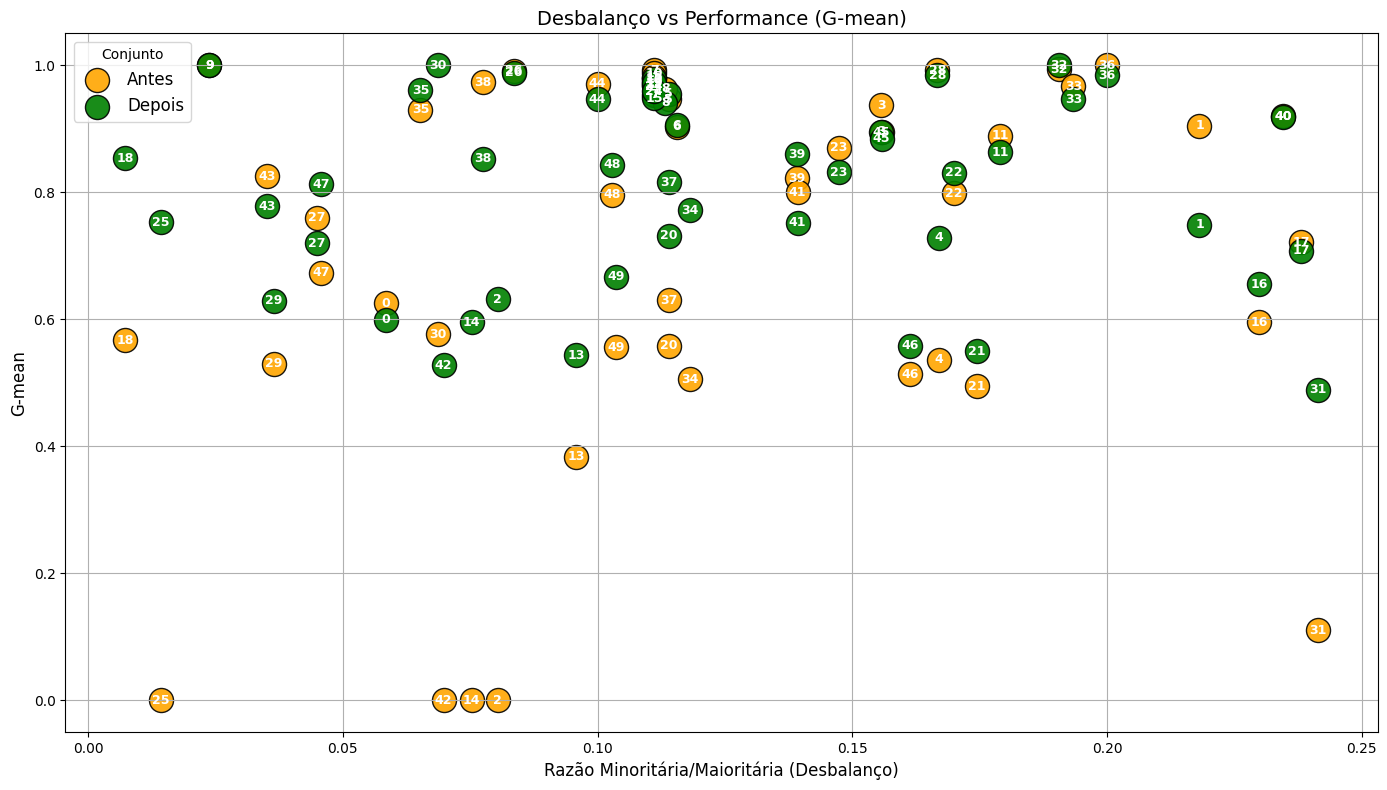

In [8]:
# Carrega os valores de G-means antes e depois das modificações,
# assim como os valores de desbalanceamento para cada dataset
gmeans_antes  = df_nao_mod['G_means']
gmeans_depois = df_mod['G_means']
imbal_ratio   = df_mod['imbal_ratio']  

plt.figure(figsize=(14, 8))

# Gráfico de dispersão para os valores antes das modificações
plt.scatter(
    imbal_ratio,
    gmeans_antes,
    s=300,
    color='orange',
    edgecolors='k',
    alpha=0.9,
    label='Antes'
)

# Gráfico de dispersão para os valores depois das modificações
plt.scatter(
    imbal_ratio,
    gmeans_depois,
    s=300,
    color='green',
    edgecolors='k',
    alpha=0.9,
    label='Depois'
)

# Ajustar margem apenas no eixo X (5%)
plt.margins(x=0.05)

#Adiciona o índice do dataset no centro de cada ponto ("Antes" e "Depois")
for i, x in enumerate(imbal_ratio):
    plt.text(x, gmeans_antes[i],  str(i),
             fontsize=9, fontweight='bold',
             ha='center', va='center', color='white')
    plt.text(x, gmeans_depois[i], str(i),
             fontsize=9, fontweight='bold',
             ha='center', va='center', color='white')
    
# Rótulos dos eixos e título
plt.xlabel('Razão Minoritária/Maioritária (Desbalanço)', fontsize=12)
plt.ylabel('G-mean', fontsize=12)
plt.title('Desbalanço vs Performance (G-mean)', fontsize=14)
# Adiciona grelha de fundo para melhor leitura
plt.grid(True)
# Legenda com título e formatação
plt.legend(title='Conjunto', fontsize=12)

plt.tight_layout()
plt.show()


**Teste de Hipótese Z para amostras emparelhadas: Melhoria no Desempenho (G-mean)**

Foi realizado um **teste de hipótese unilateral** com o objetivo de verificar se houve **melhoria significativa no G-mean** após a aplicação das técnicas.

**Hipóteses**

- **$H_0$ (Hipótese Nula):** A média das diferenças é igual a 0  
  → Não houve melhoria significativa (ou houve piora).

- **$H_1$ (Hipótese Alternativa):** A média das diferenças é maior que 0  
  → Houve melhoria significativa no G-mean após as modificações.

**Teste Estatístico**

- Utilizou-se a **estatística Z**, apropriada para amostras com tamanho razoável (via Teorema do Limite Central).
- O **valor-p** foi calculado para o lado direito da distribuição normal (teste unilateral à direita).
- Comparou-se o valor-p com um nível de significância **α = 0.001**. 

**Interpretação**

- Se o **valor-p < α**, rejeita-se H₀ → Há evidência de melhoria significativa.
- Se o **valor-p ≥ α**, não se rejeita H₀ → Não há evidência suficiente para afirmar que houve melhoria.

Este teste permite avaliar estatisticamente se as alterações no pipeline realmente tiveram impacto positivo no desempenho do modelo em cenários desbalanceados.


In [9]:
# Carrega os valores de G-means antes e depois das modificações
gmeans_antes = df_nao_mod['G_means']
gmeans_depois = df_mod['G_means']

# Calcula a diferença entre os valores "depois" e "antes"
diff = gmeans_depois - gmeans_antes


n = len(diff) # Tamanho da amostra
mean_diff = diff.mean() # Média das diferenças observadas
std_diff = diff.std(ddof=1) # Desvio-padrão amostral 
se_diff = std_diff / np.sqrt(n) # Erro padrão da média das diferenças

# Estatística Z: razão entre média observada e erro padrão
z_stat = mean_diff / se_diff

# Cálculo do p-valor para teste unilateral (Hₐ: média das diferenças > 0)
p_value = 1 - norm.cdf(z_stat)

print(f'Estatística Z: {z_stat:.4f}')
print(f'Valor-p (one-sided, > 0): {p_value:.4f}')


alpha = 0.001 # Nível de significância (α)
# Interpretação do p-valor
if p_value < alpha:
    print("Diferença significativa (rejeita-se H0)")
else:
    print("Sem diferença significativa (não se rejeita H0)")


Estatística Z: 3.2110
Valor-p (one-sided, > 0): 0.0007
Diferença significativa (rejeita-se H0)


**Conclusão do teste**

Como o **valor-p = 0.0007** é **menor que** o nível de significância **α = 0.001**, rejeita-se a hipótese nula (**H₀**).  
Isto indica que há **evidência estatística significativa** de que as modificações realizadas **melhoraram o desempenho dos modelos**, em termos de **G-mean**, em datasets desbalanceados.

Este resultado reforça a eficácia das estratégias aplicadas para lidar com o desbalanceamento de classes.

**Média, Desvio Padrão e Boxplots**

Calculamos a média e o desvio padrão dos valores de G-mean antes e depois das modificações para termos uma ideia clara do valor central e da dispersão dos resultados em cada caso. Isso ajuda a entender se houve uma mudança significativa no desempenho médio e na variabilidade.

Além disso, utilizamos boxplots para comparar visualmente as distribuições dos G-mean antes e depois. Essa visualização facilita a identificação de diferenças na mediana, variação e possíveis outliers entre os dois grupos, complementando a análise estatística numérica.

In [10]:
# Calcula a média e o desvio padrão do G-means antes das modificações
media_g_means_antes = df_nao_mod["G_means"].mean()
desvio_g_means_antes = df_nao_mod["G_means"].std()

print("Média G-means(antes):",media_g_means_antes)
print("Desvio G-means(antes):",desvio_g_means_antes)

print()

# Calcula a média e o desvio padrão do G-means depois das modificações
media_g_means_depois = df_mod["G_means"].mean()
desvio_g_means_depois = df_mod["G_means"].std()

print("Média G-means(depois):",media_g_means_depois)
print("Desvio G-means(depois):",desvio_g_means_depois)

Média G-means(antes): 0.7260073312507767
Desvio G-means(antes): 0.2962742267619891

Média G-means(depois): 0.8156518707823984
Desvio G-means(depois): 0.1505927131141617


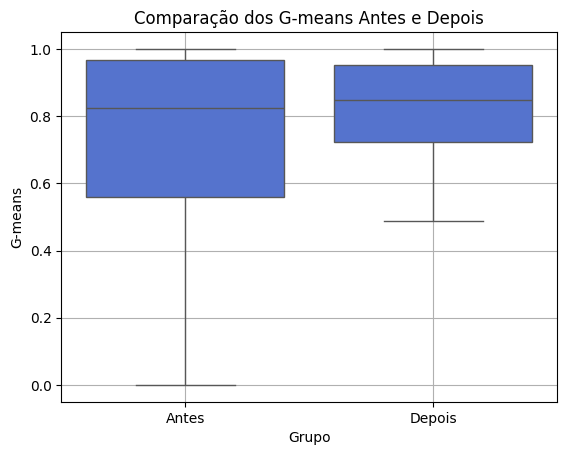

In [11]:
# Cria um DataFrame auxiliar para visualização comparativa dos G-means
df_plot = pd.DataFrame({
    'G_means': pd.concat([gmeans_antes, gmeans_depois], ignore_index=True),
    'Grupo': ['Antes'] * len(gmeans_antes) + ['Depois'] * len(gmeans_depois)
})

# Cria os boxplots comparativos entre os valores de G-means antes e depois das modificações
sns.boxplot(x='Grupo', y='G_means', data=df_plot,color="royalblue")
plt.title('Comparação dos G-means Antes e Depois')
plt.ylabel('G-means')
plt.grid(True)
plt.show()

**Resultados observados**

 - A média dos G-mean aumentou de aproximadamente 0.73 para 0.82 após as modificações.

 - O desvio padrão diminuiu, indicando uma menor variabilidade nos resultados depois das mudanças.

 - Os boxplots mostram distribuições claramente diferentes, confirmando que houve uma alteração significativa no desempenho.

Esses resultados indicam que as modificações aplicadas tiveram impacto positivo e consistente na performance medida pelo G-mean.

### Casos em que o G-mean piorou

Em alguns datasets, observou-se uma diminuição do G-mean após a modificação.

Para avaliar se, mesmo nesses casos, o objetivo principal foi alcançado:  melhorar a taxa de acerto da classe minoritária,analisamos diretamente a métrica que representam o desempenho na classe minoritária.

Esse passo é fundamental porque o G-mean representa um equilíbrio entre Recall e Specificity, e uma redução nesta métrica não implica necessariamente que piorou naquilo que é mais importante: detectar corretamente a classe menos representada. 

Assim, a análise foca em verificar se, apesar da queda no G-mean, houve ganho na métrica associada à classe minoritária, o que ainda pode justificar o uso da modificação.

Essa abordagem garante que a avaliação da modificação não se baseie apenas em uma métrica agregada, mas sim em um olhar de forma mais direcionado para o problema do desbalanceamento.

Após identificar os datasets cujo valor de G-mean piorou, após a modificação, investigámos se, apesar disso, houve melhoria na métrica mais relevante para a classe minoritária (Recall ou Specificity, dependendo do caso).

Para isso:

- Calculámos a diferença na métrica crítica entre antes e depois para cada um dos datasets (metric_diff);

- Obtivemos a média dessa diferença para verificar se, em geral, houve algum ganho relevante;

- Produzimos um gráfico de dispersão numerado onde cada ponto representa a diferença da métrica crítica por dataset. Isso permitiu observar facilmente quais casos melhoraram e quais pioraram;

- Finalmente, foi criada uma tabela de legenda que relaciona os números do gráfico com os nomes dos datasets, facilitando a interpretação dos resultados.

Essa visualização ajudou a concluir se as modificações aplicadas, mesmo em cenários onde o G-mean caiu, ainda foram benéficas no objetivo principal: melhorar a performance sobre a classe minoritária.

In [12]:
# Cria uma máscara booleana que identifica os datasets cujo G-mean piorou após a modificação
mask = df_nao_mod['G_means'] > df_mod['G_means']

#  Constrói um novo DataFrame apenas com os datasets onde o G-mean piorou
df_filtrado = pd.DataFrame({
    'DataSet'               : df_nao_mod.loc[mask, 'DataSet'],
    'Recall_nao_mod'        : df_nao_mod.loc[mask, 'Recall'],
    'Recall_mod'            : df_mod.loc[mask,     'Recall'],
    'Specificity_nao_mod'   : df_nao_mod.loc[mask, 'Specificity'],
    'Specificity_mod'       : df_mod.loc[mask,     'Specificity'],
    'metric_minority'       : df_nao_mod.loc[mask, 'metric_minority'],
    'G_means_antes'         : df_nao_mod.loc[mask, 'G_means'],
    'G_means_depois'        : df_mod.loc[mask,     'G_means'],
})

# Calcula a diferença do G-means entre antes e depois
df_filtrado['G_diff'] = df_filtrado['G_means_antes'] - df_filtrado['G_means_depois']

# Calcula a diferença da métrica de interesse para a classe minoritária (Recall ou Specificity)
df_filtrado['metric_diff'] = np.where(
    df_filtrado['metric_minority'] == 'recall',
    df_filtrado['Recall_mod'] - df_filtrado['Recall_nao_mod'],
    df_filtrado['Specificity_mod'] - df_filtrado['Specificity_nao_mod']
)

#  Remove as colunas intermediárias de G-means (já usadas no cálculo)
df_filtrado = df_filtrado.drop(columns=['G_means_antes', 'G_means_depois'])

# Reindexa o DataFrame resultante para organização
df_filtrado = df_filtrado.reset_index(drop=True)

df_filtrado

,DataSet,Recall_nao_mod,Recall_mod,Specificity_nao_mod,Specificity_mod,metric_minority,G_diff,metric_diff
0,dataset_1045_kc1-top5.csv,0.978042,0.897619,0.400000,0.400000,specificity,0.026268,0.000000
1,dataset_312_scene.csv,0.835392,0.830500,0.979753,0.674585,recall,0.156204,-0.004892
2,dataset_1023_soybean.csv,0.891228,0.935673,0.984774,0.856530,recall,0.041607,0.044444
3,dataset_962_mfeat-morphological.csv,0.985000,0.960000,0.998889,0.946111,recall,0.038890,-0.025000
4,dataset_980_optdigits.csv,0.930053,0.938810,0.996038,0.943347,recall,0.021405,0.008757
5,dataset_971_mfeat-fourier.csv,0.975000,0.960000,1.000000,0.995000,recall,0.010078,-0.015000
6,dataset_940_water-treatment.csv,0.825000,0.825000,0.957453,0.901673,recall,0.026278,0.000000
7,dataset_978_mfeat-factors.csv,0.960000,0.960000,0.999444,0.978889,recall,0.010125,0.000000
8,dataset_1022_mfeat-pixel.csv,0.965000,0.915000,0.998333,0.982222,recall,0.033510,-0.050000
9,dataset_867_visualizing_livestock.csv,0.866667,0.695238,0.600000,0.720000,specificity,0.013600,0.120000


In [13]:
print("Em média houve uma variação de :",df_filtrado["metric_diff"].mean())


Em média houve uma variação de : 0.01735916960900781


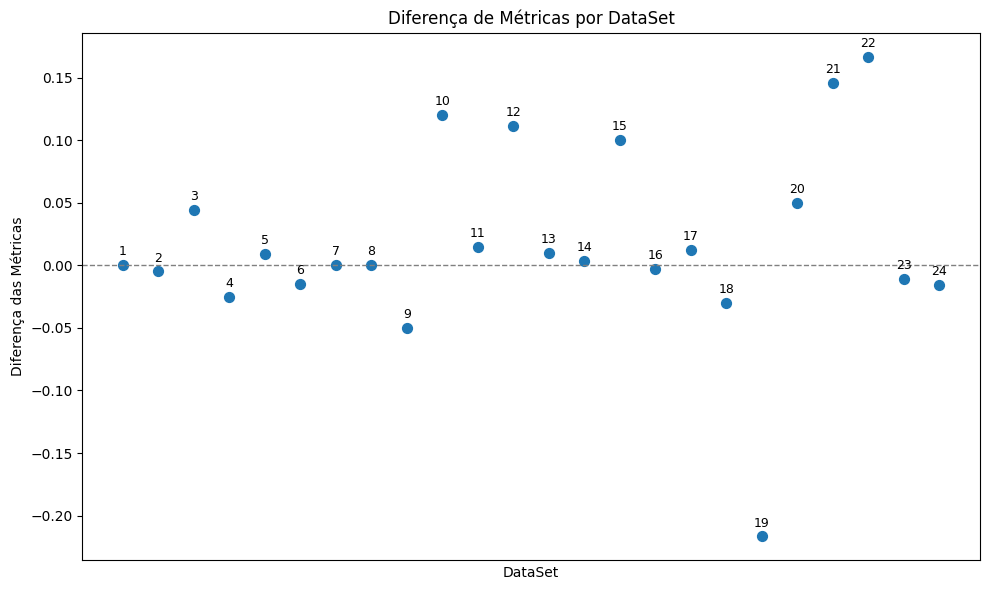

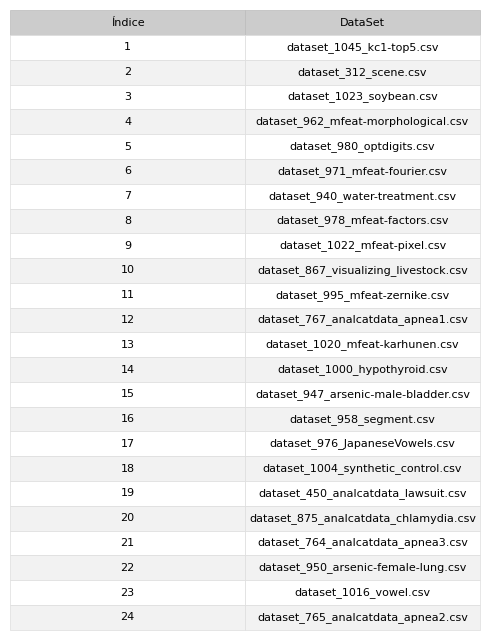

In [14]:
# Extrai os nomes dos datasets e as diferenças nas métricas da classe minoritária
datasets = df_filtrado['DataSet']
diffs    = df_filtrado['metric_diff']
indices  = list(range(1, len(datasets) + 1)) # Cria uma lista de índices numéricos para identificação

# --- Figura 1: Scatter Plot numerado ---
plt.figure(figsize=(10, 6))

# Plota os pontos representando a diferença das métricas para cada dataset
plt.scatter(indices, diffs, s=50)
# Linha horizontal em y=0 para referência visual (acima = melhoria, abaixo = piora)
plt.axhline(0, color='grey', linewidth=1, linestyle='--')

# Adiciona o número de índice sobre cada ponto no gráfico
for idx, y in zip(indices, diffs):
    plt.annotate(
        str(idx),
        xy=(idx, y),
        xytext=(0, 5),
        textcoords='offset points',
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.xticks([])  
plt.xlabel('DataSet')
plt.ylabel('Diferença das Métricas')
plt.title('Diferença de Métricas por DataSet')
plt.tight_layout()
plt.show()

# ----------------------
# Tabela auxiliar de legenda para associar índices aos nomes dos datasets
# ----------------------

# Cria o DataFrame que liga o índice ao nome do dataset
datasets = df_filtrado['DataSet']
indices  = list(range(1, len(datasets) + 1))


table_df = pd.DataFrame({
    'Índice': indices,
    'DataSet': datasets
})


fig, ax = plt.subplots(figsize=(5, len(table_df)*0.25 + 0.5))
ax.axis('off')


header_color = '#cccccc'
row_colors = ['#ffffff', '#f2f2f2']


cell_colors = []
for i in range(len(table_df)):
    cell_colors.append([row_colors[i % 2]] * table_df.shape[1])
col_colors = [header_color] * table_df.shape[1]

# Cria a tabela com o conteúdo e estilo definidos
tbl = ax.table(
    cellText=table_df.values,
    colLabels=table_df.columns,
    cellColours=cell_colors,
    colColours=col_colors,
    cellLoc='center',
    colLoc='center',
    loc='center'
)

# Ajustes de estilo e espaçamento da tabela
tbl.auto_set_font_size(False)
tbl.set_fontsize(8)
tbl.scale(1, 1.2)

for (row, col), cell in tbl.get_celld().items():
    if row > 0:
        cell.set_edgecolor('#dddddd')
    else:
        cell.set_edgecolor('#bbbbbb')
    cell.set_linewidth(0.5)

plt.tight_layout()
plt.show()



Embora nem todos os datasets tenham apresentado uma melhoria no G-mean após a aplicação das modificações, observou-se que, em média, houve um aumento de aproximadamente 0,01736 na taxa de acerto da classe minoritária. Este resultado é especialmente relevante em contextos de desequilíbrio de classes, onde o desempenho sobre a minoria é frequentemente negligenciado por métricas globais.

Isso demonstra que, mesmo nos casos em que o G-mean sofreu uma ligeira redução, o objetivo central da modificação foi, de forma geral, atingido: melhorar a capacidade do modelo em reconhecer corretamente os exemplos da classe menos representada.

Portanto, a estratégia adotada mostrou-se eficaz no reforço da equidade entre classes, evidenciando uma melhoria concreta naquilo que mais importa em cenários desbalanceados.